In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import random
import matplotlib.pyplot as plt

from diffusers import AutoencoderKL
from PIL import Image
import torch.nn.functional as F

/home/juriostegui/work/env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/juriostegui/work/env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# image load

In [2]:
# Set dataset path
dataset_path = "/scratch/juriostegui/sun397-subset/test/"

# Image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load dataset from folder
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)


# image preproccessing

In [3]:
# Function to create random square mask
def random_square_mask(img_tensor):
    _, H, W = img_tensor.shape
    h = H // 2
    w = W // 2
    top = random.randint(0, H - h)
    left = random.randint(0, W - w)
    mask = torch.zeros(1, H, W, device=img_tensor.device)
    mask[:, top:top+h, left:left+w] = 1.0

    masked_img = img_tensor.clone()
    masked_img[:, top:top+h, left:left+w] = 0.0
    return masked_img, mask

In [4]:
# Pick 5 random images
images = []
masks = []
masked_images = []

for i, (img, _) in enumerate(data_loader):
    if i >= 5:
        break
    img = img[0].cuda()
    masked_img, mask = random_square_mask(img)
    images.append(img.cpu())
    masked_images.append(masked_img.cpu())
    masks.append(mask.cpu())

# mask down scaling

In [2]:
# Load Stable Diffusion VAE
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").to("cuda")
vae.eval()


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/home/juriostegui/work/env/lib/python3.11/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [6]:
# Encode original images (without mask)
latents = []
for img in images:
    img = img.unsqueeze(0).cuda()
    with torch.no_grad():
        latent = vae.encode(img).latent_dist.sample() * vae.config.scaling_factor
    latents.append(latent.cpu())

In [7]:
# Downsample masks to latent space
latent_masks = []
for mask in masks:
    mask_tensor = mask.unsqueeze(0).cuda()
    # VAE latent is typically 1/8 resolution
    latent_mask = F.interpolate(mask_tensor, scale_factor=1/8, mode="nearest")
    latent_masks.append(latent_mask.cpu())

In [8]:
# Apply mask in latent space
masked_latents = []
for latent, lmask in zip(latents, latent_masks):
    
    masked_latent = latent * (1 - lmask)
    masked_latents.append(masked_latent)

## Plot 

In [9]:
# Decode masked latent images
decoded_imgs = []
for masked_latent in masked_latents:
    masked_latent = masked_latent.cuda()
    with torch.no_grad():
        decoded_img = vae.decode(masked_latent / vae.config.scaling_factor).sample
    decoded_imgs.append(decoded_img.cpu())

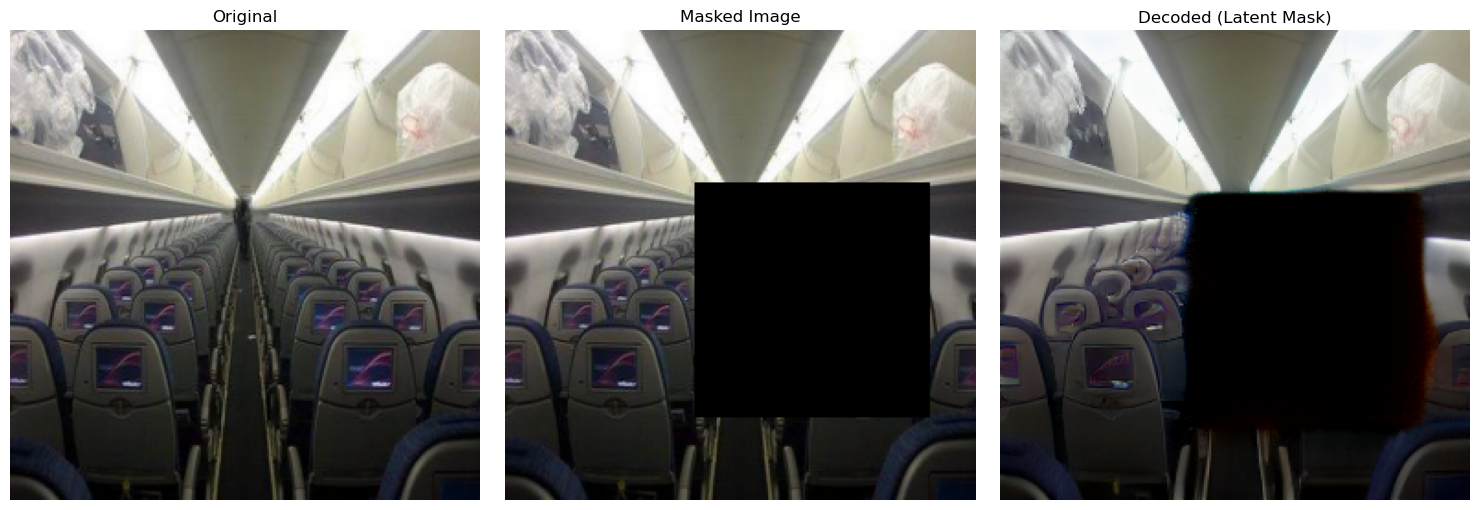

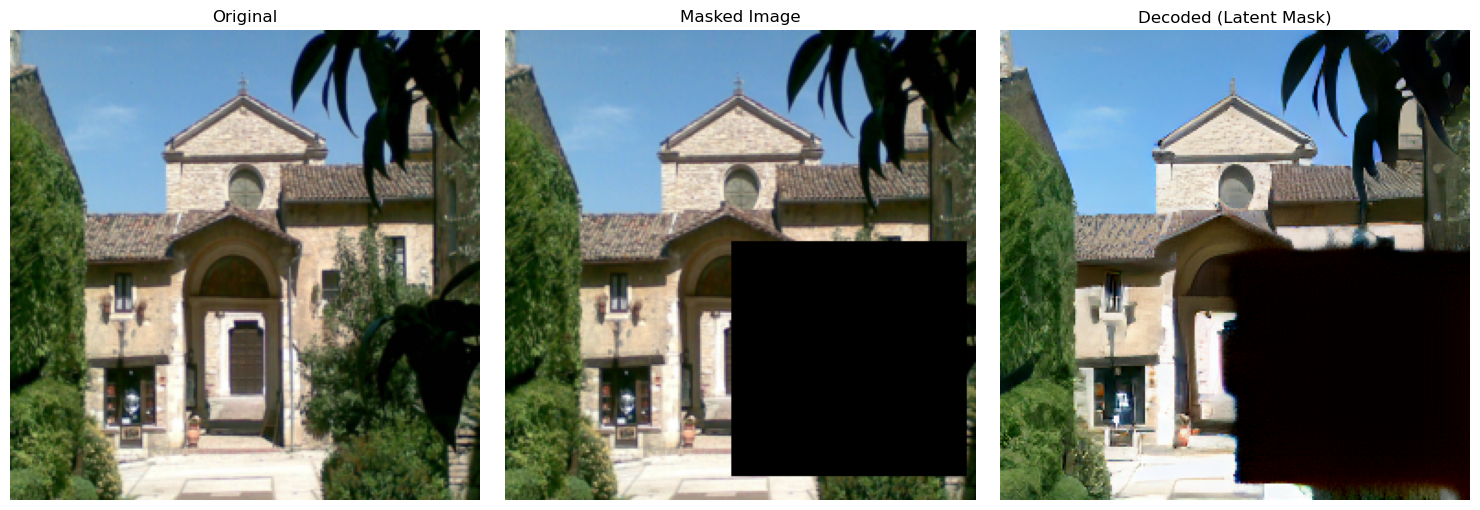

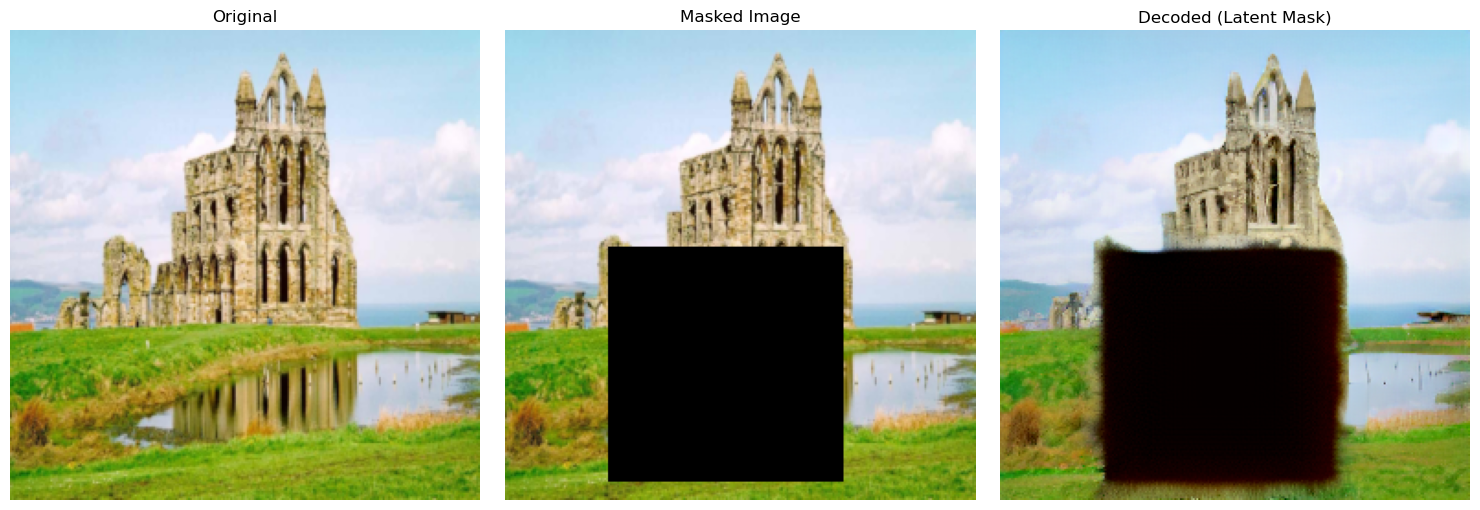

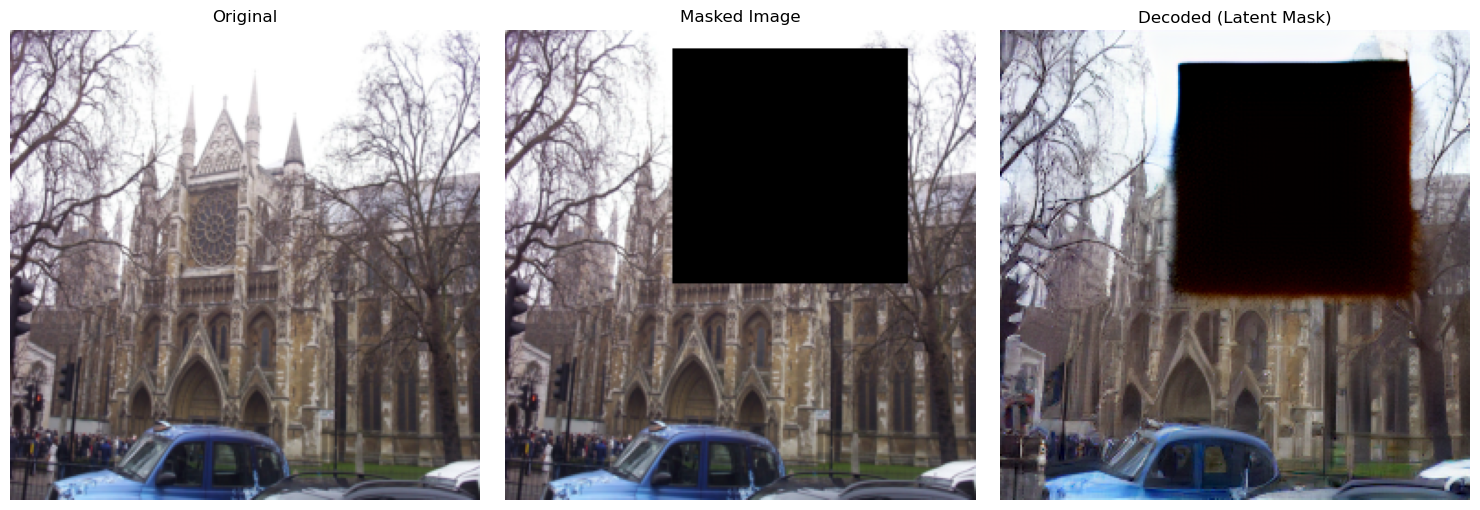

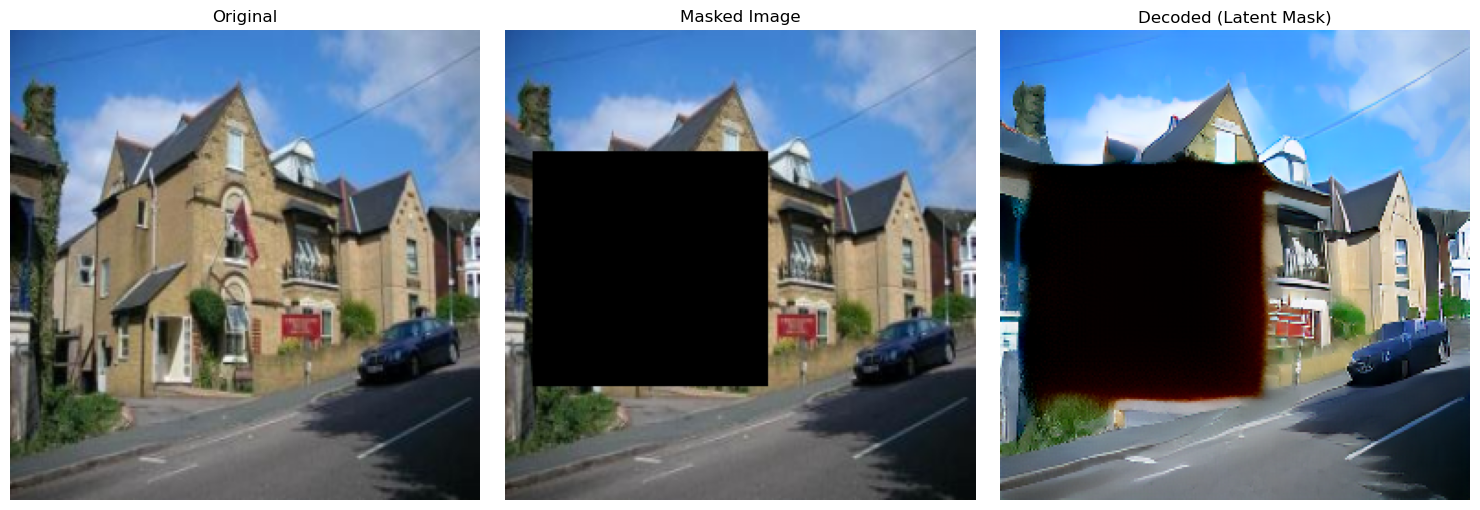

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(5):
    orig = images[i].detach().cpu().permute(1, 2, 0).clamp(0, 1)
    masked = masked_images[i].detach().cpu().permute(1, 2, 0).clamp(0, 1)
    decoded = decoded_imgs[i][0].detach().cpu().permute(1, 2, 0).clamp(0, 1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(orig)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(masked)
    axes[1].set_title("Masked Image")
    axes[1].axis("off")

    axes[2].imshow(decoded)
    axes[2].set_title("Decoded (Latent Mask)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


# dif. text condition

In [5]:
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from transformers import CLIPTokenizer
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F



In [6]:
# --- Step 1: Load the Stable Diffusion model ---
model_id = "runwayml/stable-diffusion-v1-5"  # you can change to SDXL if needed

pipe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16
).to("cuda")

unet = pipe.unet
tokenizer = pipe.tokenizer
vae = pipe.vae



Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
# --- Step 3: Encode image into latent space ---
def preprocess_image(img, vae):
    # assume img is [C,H,W] or [1,C,H,W] torch tensor
    if img.max() > 1.0:
        img = img / 255.0
    img = img * 2 - 1  # scale to [-1,1]
    if img.ndim == 3:
        img = img.unsqueeze(0)
    
    # move to device and match dtype of VAE
    device = next(vae.parameters()).device
    dtype = next(vae.parameters()).dtype
    img = img.to(device=device, dtype=dtype)
    
    with torch.no_grad():
        latent = vae.encode(img).latent_dist.sample() * 0.18215
    return latent



z = preprocess_image(masked_img, vae)


In [10]:
# --- Step 4: Tokenize your prompt ---
prompt = "mask the square"  # prompt describing the region to mask
tokens = tokenizer(prompt, return_tensors="pt").to("cuda")
token_index = tokenizer.convert_tokens_to_ids("square")  # target token
# Note: you can verify with tokenizer.decode([token_index])



In [45]:
def save_attention_hook(module, input, output):
    print("=== Inside hook ===")
    print("Module:", module.__class__.__name__)
    print("Output type:", type(output))
    print("Output shape:", output.shape if isinstance(output, torch.Tensor) else None)
    
    if hasattr(module, "get_attention_probs"):
        attn_probs = module.get_attention_probs()
    else:
        print("Output is not tuple, cannot access output[1]")
        attn_probs = None  # safely skip for debugging
    
    if attn_probs is not None:
      token_mask = (tokens['input_ids'][0] == token_index).nonzero(as_tuple=True)[0]
      token_attn = attn_probs[0, :, token_mask, :].mean(0)
      attention_maps.append(token_attn.detach().cpu())
    else:
      print("Skipping this layer, no attention probs available")

    print("Number of attention maps:", len(attention_maps))
    for i, m in enumerate(attention_maps):
        print(f"{i}: type={type(m)}, shape={m.shape if isinstance(m, torch.Tensor) else 'N/A'}")

    if all(isinstance(m, torch.Tensor) for m in attention_maps):
        soft_mask = fuse_and_upsample(attention_maps)
    else:
        print("Error: attention_maps contains non-tensors")



In [46]:
# --- Step 6: Run UNet forward pass (1 step) ---
# You can add dummy noise timestep t=0.3
# Get text embeddings from the text encoder (CLIP)
with torch.no_grad():
    text_embeddings = pipe.text_encoder(tokens['input_ids'])[0]

# Now pass these embeddings to UNet
with torch.no_grad():
    _ = unet(z, torch.tensor([0.3]).to("cuda"), encoder_hidden_states=text_embeddings)

# Remove hooks
for h in hooks:
    h.remove()



In [39]:
# --- Step 7: Aggregate attention maps and upsample to image size ---
def fuse_and_upsample(att_maps, target_size=(512, 512)):
    # att_maps: list of 1D flattened tensors
    fused = torch.stack([m.reshape(1,1,int(np.sqrt(len(m))),int(np.sqrt(len(m)))) for m in att_maps], dim=0)
    fused = fused.mean(0)  # mean over layers
    upsampled = F.interpolate(fused, size=target_size, mode='bilinear', align_corners=False)
    mask = upsampled.squeeze().numpy()
    mask = (mask - mask.min()) / (mask.max() - mask.min())  # normalize to [0,1]
    return mask

soft_mask = fuse_and_upsample(attention_maps)



AttributeError: 'str' object has no attribute 'reshape'

In [ ]:
# --- Step 8: Visualize soft mask ---
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(soft_mask, cmap="inferno")
plt.title("Soft Attention Mask")
plt.axis("off")
plt.show()

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline for runwayml/stable-diffusion-v1-5 on cuda...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Target indices for 'square': [3]
Running UNet forward pass to extract attention maps...
Restoring original UNet processors...

Soft Mask generated for 'square'. Shape: (512, 512)


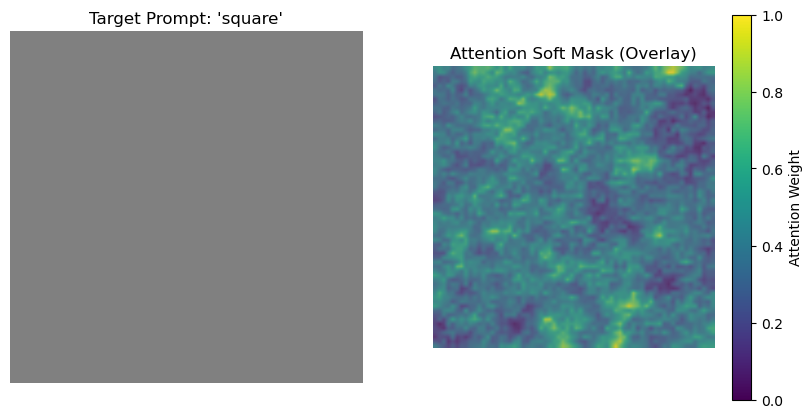

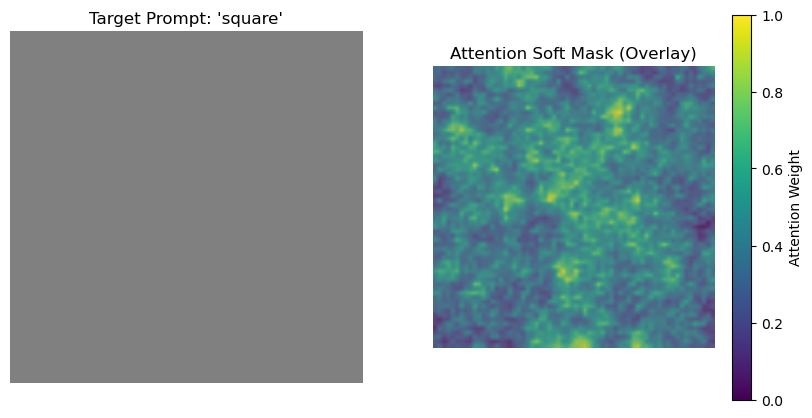

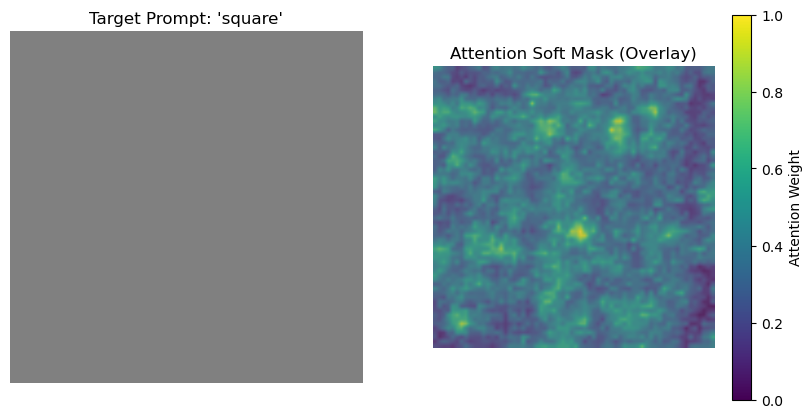

In [36]:
%matplotlib inline
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from diffusers import StableDiffusionPipeline
from diffusers.models.attention_processor import AttnProcessor, Attention

# --- 1. SETUP: DEVICE AND PIPELINE LOADING ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "runwayml/stable-diffusion-v1-5" # Or any SD 1.x model

print(f"Loading pipeline for {model_id} on {device}...")
# Use the components you already loaded, or load the whole pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16 if device == "cuda" else torch.float32)
pipe.to(device)

# --- 2. INPUTS AND PARAMETERS ---
prompt = "A red square on a blue background"
target_word = "square" # The word you want to generate a mask for
image_size = (512, 512)
latent_size = image_size[0] // 8
z_size = (1, 4, latent_size, latent_size) # SD 1.5 latent shape
guidance_scale = 0.3 # Use a low value for demonstration/initial step

# --- 3. FIX: CUSTOM ATTENTION PROCESSOR CLASS ---
# Global storage for all attention maps
attention_maps = {}

class AttnMapSaver(AttnProcessor):
    """Custom processor that saves attention maps from cross-attention (attn2)."""
    
    def __init__(self, attn_maps_dict):
        super().__init__()
        self.attn_maps_dict = attn_maps_dict

    def __call__(
        self,
        attn: Attention,
        hidden_states,
        encoder_hidden_states=None,
        attention_mask=None,
        temb=None,
        scales=None,
    ):
        # 1. Standard cross-attention forward pass (modified to extract probs)
        residual = hidden_states
        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size = hidden_states.shape[0]

        query = attn.to_q(hidden_states)
        encoder_hidden_states = encoder_hidden_states if encoder_hidden_states is not None else hidden_states
        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        if attn.upcast_attention:
            query = query.float()
            key = key.float()
            
        # Attention score calculation
        attn_scores = torch.baddbmm(
            torch.empty(query.shape[0], query.shape[1], key.shape[1], dtype=query.dtype, device=query.device),
            query,
            key.transpose(1, 2),
            beta=0,
            alpha=attn.scale,
        )
        
        # 2. Attention Probabilities (softmax)
        attn_probs = attn_scores.softmax(dim=-1).to(query.dtype)

        # 3. SAVE THE ATTENTION MAP HERE (Only for cross-attention)
        if encoder_hidden_states is not None:
            layer_name = f"attn2_{id(attn)}" 
            self.attn_maps_dict[layer_name] = attn_probs.detach().cpu()

        # Final output calculation
        hidden_states = torch.bmm(attn_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        hidden_states = attn.to_out[0](hidden_states)
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual
        
        hidden_states = hidden_states / attn.rescale_output_factor
        return hidden_states

# --- 4. PREPARE: TOKENIZATION AND TARGET INDEX ---

# 1. Tokenize the prompt
tokens = pipe.tokenizer(
    prompt,
    padding="max_length",
    truncation=True,
    max_length=pipe.tokenizer.model_max_length,
    return_tensors="pt"
).to(pipe.device)

# 2. Get the token ID for the target word
target_token_ids = pipe.tokenizer.encode(target_word, add_special_tokens=False)
if not target_token_ids:
    raise ValueError(f"Could not tokenize target word: '{target_word}'.")

# 3. Find ALL indices where the first token ID appears (e.g., if 'square' is tokenized into multiple parts)
# We focus on the indices of the token(s) that make up the target word.
target_indices = []
input_ids = tokens['input_ids'][0]
for token_id in target_token_ids:
    target_indices.extend((input_ids == token_id).nonzero(as_tuple=True)[0].tolist())

if not target_indices:
    raise ValueError(f"Target word '{target_word}' not found in the tokenized prompt.")

target_indices = torch.tensor(target_indices, device='cpu')
print(f"Target indices for '{target_word}': {target_indices.tolist()}")


# --- 5. EXTRACTION: ATTACH PROCESSOR AND RUN UNET FORWARD PASS ---

# Initialize the processor instance and UNet
saver_processor = AttnMapSaver(attention_maps)
unet = pipe.unet
unet.to(device)

# 1. Attach the custom processor to all cross-attention layers (attn2)
original_processors = {}
for name, module in unet.named_modules():
    # Only target Cross-Attention layers (attn2)
    if isinstance(module, Attention) and 'attn2' in name:
        original_processors[name] = module.processor
        module.set_processor(saver_processor)

# 2. Prepare random latent input (z) and text embeddings
z = torch.randn(z_size, device=device, dtype=pipe.dtype)
text_embeddings = pipe.text_encoder(tokens['input_ids'])[0]

# 3. Run the UNet forward pass at t=0.3 (or any small timestep)
print("Running UNet forward pass to extract attention maps...")
with torch.no_grad():
    # This call now uses the custom processor, populating 'attention_maps'
    _ = unet(z, torch.tensor([guidance_scale]).to(device), encoder_hidden_states=text_embeddings)

# 4. Detach the custom processor and restore originals
print("Restoring original UNet processors...")
for name, module in unet.named_modules():
    if name in original_processors:
        module.set_processor(original_processors[name])

# --- 6. PROCESSING: FUSE AND UPSAMPLE (FINAL CORRECTED VERSION) ---

def fuse_and_upsample(attention_maps, target_indices, target_size, latent_size):
    """
    Fuses attention maps for the specified target token(s), averages them,
    and upsamples to the target image size.
    """
    att_maps_list = []
    standard_latent_size = (latent_size, latent_size)

    # Iterate through all saved cross-attention maps
    for layer_name, attn_map_all_tokens in attention_maps.items():
        # 1. Select and average attention values for the target token(s)
        # Result shape: [B*H, S]
        token_attention = attn_map_all_tokens[:, :, target_indices].mean(dim=-1).mean(dim=0)
        
        # 2. Reshape the 1D spatial tokens back into a 2D feature map
        S = token_attention.shape[-1]
        current_latent_dim = int(np.sqrt(S))
        
        token_attention_2d = token_attention.reshape(1, 1, current_latent_dim, current_latent_dim).float()
        
        # 3. UPSCALE CURRENT MAP TO THE STANDARD LARGEST LATENT SIZE (e.g., 64x64)
        if current_latent_dim != latent_size:
            token_attention_2d = F.interpolate(
                token_attention_2d, 
                size=standard_latent_size, 
                mode='bilinear', 
                align_corners=False
            )
            
        att_maps_list.append(token_attention_2d)

    if not att_maps_list:
        print("Error: No attention maps were extracted.")
        return np.zeros(target_size)
        
    # 5. Fuse all attention maps (now all of the same size)
    fused = torch.cat(att_maps_list, dim=0) # Shape: [Num_Layers, 1, L, L]
    
    # FIX: Use keepdim=True to maintain the 4D shape: [1, 1, L, L]
    fused = fused.mean(0, keepdim=True) 

    # 6. Upsample to the original image size (Now correctly sees 2 spatial dims)
    upsampled = F.interpolate(fused, size=target_size, mode='bilinear', align_corners=False)
    
    # 7. Final normalization
    mask = upsampled.squeeze().numpy()
    if mask.max() > mask.min():
        mask = (mask - mask.min()) / (mask.max() - mask.min())
    
    return mask

# --- Call the fixed function (Update the call site) ---
# Assuming latent_size (e.g., 64 for 512x512 image) is already defined
soft_mask = fuse_and_upsample(
    attention_maps, 
    target_indices, 
    target_size=image_size, 
    latent_size=latent_size # Pass the largest latent size
)

# --- 7. FINAL EXECUTION AND VISUALIZATION ---

print(f"\nSoft Mask generated for '{target_word}'. Shape: {soft_mask.shape}")

# Optional: Generate a dummy image for visualization purposes
dummy_image = np.array(Image.new('RGB', image_size, color = 'gray'))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(dummy_image)
plt.title(f"Target Prompt: '{target_word}'")
plt.axis("off")

plt.subplot(1, 2, 2)
# Display the mask on top of the dummy image for context
plt.imshow(dummy_image, alpha=1.0)
plt.imshow(soft_mask, cmap='viridis', alpha=0.7) # Use alpha to see through, cmap for color
plt.title(f"Attention Soft Mask (Overlay)")
plt.axis("off")

plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=plt.gca(), label='Attention Weight')
plt.show()

# To use this mask for image generation, you would typically convert it to a binary mask
# e.g., binary_mask = soft_mask > 0.5